In [1]:
from random import shuffle
import operator
import numpy as np
import matplotlib.pyplot as plt
from numpy.core.numeric import argwhere
import matplotlib.patches as patches
from pylab import *
mpl.rcParams['font.sans-serif'] = ['SimHei']
import matplotlib.pyplot as plt

In [2]:
# 1、获取任务具体资源和未获取资源任务数量 ( 某一资源内部 )
#    根据资源(字典) + 在资源中的任务需求(list) + 和任务排序序列（list） ------> 任务具体安排的位置 + 没有安排资源的任务数量（int）

def get_position(source, size, arranged_order):             # 已知任务时频需求和卫星转发器资源，返回每个任务的位置 （x，y，w，h），利用 source 主要是需要资源的开始、结束时间、频率
    initial_grid = np.zeros((source['max_f']-source['min_f']+1, source['max_t']-source['min_t']+1))             # 初始化资源网格
    A = np.zeros([len(size), 4])        # 初始化全零任务的位置矩阵
    counter_unarranged = 0              # 没有获取资源任务数量

    for i in range(len(arranged_order)):
        [start_time, end_time, band_width] = size[arranged_order.index(i+1)]                   # i=0-7, i+1=1-8，先找顺序为1的任务索引，根据索引将size中元素赋给 start_time, end_time, band_width
        timerange_source_available = np.sum(initial_grid[:, (start_time+1):end_time], axis=1)           # 将任务时间范围内每一行资源相加，判断某频率上是否有可用资源，0为空余，否则资源不可用
        if band_width > source['max_f']-source['min_f']:
            counter_unarranged += 1
        if band_width <= source['max_f']-source['min_f']:
            for y in range(source['max_f']-source['min_f']-band_width+1):                                                  # 任务需要连续带宽，所以需要看时间范围内是否有连续的频率段都为0
                continuous_f_source_available = sum(timerange_source_available[y+1:y+band_width])         # 将时间范围内连续带宽资源的值求和，如果为0，此段频率资源可用，如果不为0，此段频率资源不可用，换下一段
                if continuous_f_source_available == 0:
                    start_f = y + source['min_f']                                                                            # 此时 y 为任务左下角纵坐标
                    A[i] = [start_time, start_f, end_time-start_time, band_width]     # 用 A 的四个向量表示任务 （x，y，w，h）
                    initial_grid[y:y+band_width+1, start_time:start_time+(end_time-start_time)+1] = np.ones((band_width+1, end_time-start_time+1))              # 更新网格数据
                    break
                if y == source['max_f']-source['min_f']-band_width:
                    counter_unarranged += 1
    return A, counter_unarranged

In [3]:
# 根据某一个具体基因型，得出该基因型（ individual_resource，individual_order ）对应的任务卫星调度资源，和未分配资源任务数量

def gene_position(gene, show_resource_size_order, show_task_position):

    individual_resource = gene[:DNA_SIZE].tolist()                # pop_resource 为可以重复的序列，进行简单交叉变异
    individual_order = gene[DNA_SIZE:].tolist()  


    #----------获取各个资源中的任务时频需求size集合，resource_task_size[j] 表示 “资源j” 分配的 size 集合------------
    resource_task_size = []                                 # "资源j" 任务的时频资源矩阵，用来存储 "资源j" 对应 任务的size
    for j in range(len(satellite_resource)):                # 将所有资源的任务矩阵初始化，生成资源数量个[]，eg：resource_task_size = [[],[],[]]
        resource_task_size.append([])

    for i in range(DNA_SIZE):                               # 如果 "任务i" 对应 "资源j" ，将 "任务i" 的 size 放入 "资源j" 的[] 中
        for j in range(len(satellite_resource)):
            if individual_resource[i] == j:
                resource_task_size[j].append(size[i].tolist())


    #----------获取各个资源中的任务时频资源order集合，resource_task_order[j] 表示 “资源j” 中任务的排样顺序------------
    resource_task_order_old = []                            # "资源j" 任务的不连续排样顺序，用来存储 "资源j" 对应 任务的任务排样顺序， _old 表示初次筛选出来的顺序，不连续
    for j in range(len(satellite_resource)):                # 将所有资源的顺序矩阵初始化，生成资源数量个[]，eg：resource_task_order_old = [[],[],[]]
        resource_task_order_old.append([])
    resource_task_order = resource_task_order_old           # "资源j" 任务的真实排样顺序，用来存储 "资源j" 对应 任务的真实任务排样顺序， 矩阵大小与 _old 相等

    for i in range(DNA_SIZE):                               # 如果 "次序i" 对应 "资源j" ，将 "次序i" 的值放入 "资源j" 的[] 中
        for j in range(len(satellite_resource)):
            if individual_resource[i] == j:
                resource_task_order_old[j].append(individual_order[i])

    for j in range(len(satellite_resource)):                # 将每一 "资源j" 内部的杂乱、间断的排样次序重新排列
        resource_task_order[j] = to_correct_order(resource_task_order_old[j]).tolist()          
    

    # ----------是否输出 “资源j” 对应的 "任务size集合" 和 "任务排入次序"
    if show_resource_size_order == 'yes':
        for j in range(len(satellite_resource)):
            print(f'资源{j}的任务：\n{resource_task_size[j]} \n资源{j}任务排入次序：\n{resource_task_order[j]}')


    #---------- 在各个资源中对任务分配具体资源，并记录未分配资源任务个数------------
    task_position = []
    counter_unarranged_task = 0

    source_name = []
    for key in satellite_resource.keys():
        source_name.append(key)

    for j in range(len(satellite_resource)):
        task_position_source_j, counter_unarranged_j = get_position(satellite_resource[source_name[j]], np.array(resource_task_size[j]), resource_task_order[j])          # task_position_0 为资源0中，已分配资源任务的获取资源详情；counter_unarranged_0 为使用资源0，但是未分配资源的任务个数
        counter_unarranged_task += counter_unarranged_j
        for a in task_position_source_j:
            task_position.append(a.tolist())


    # ----------是否输出 “本基因型” 对应的 "任务资源分配情况" 和 "未安排资源任务数量"
    if show_task_position == 'yes':
        print(f'该基因行任务资源分配情况：\n{task_position} \n未分配资源任务个数：\n{counter_unarranged_task}')


    return task_position, counter_unarranged_task

    

In [4]:
# 2、根据任务（x,y,w,h) 画出任务甘特图，A 为任务位置集合

def show_rec(individual_gene):
    task_position, unarranged_task_amount = gene_position(individual_gene, show_resource_size_order = 'yes', show_task_position = 'yes')
    task_position = np.array(task_position)
    ax = plt.subplot(111)
    ax.axis([min(task_position[:,0]), max(task_position[:,0]+task_position[:,2]+5), 0, max(task_position[:,1]+task_position[:,3]+5)])
    for i in range(len(task_position)):
            ax.add_patch(patches.Rectangle((task_position[i,0], task_position[i,1]), task_position[i,2], task_position[i,3], linewidth=1, edgecolor='black'))                   # , facecolor='green'

    plt.xlabel("w")
    plt.ylabel("t")

In [5]:
# 3、将每个资源任务提取出来后，任务顺序混乱且不连续，输入混乱不连续的任务顺序列表[]，返回按大小排列的资源内部正确任务排列顺序array[]

def to_correct_order(old_order):

    new_order = np.zeros(len(old_order))          # 初始化所有顺序都为 0

    counter = 1                                             # 计数器，将值赋给最小顺序值

    for i in range(len(old_order)):
        first_order_index = old_order.index(min(old_order))         # 原先顺序的最小值索引
        new_order[first_order_index] = counter                                             # 将计数器值赋给原先顺序最小值
        counter += 1                                                                    # 计数器加一，下一轮赋值给第二靠前任务
        old_order[first_order_index] = max(old_order)+1             # 将最小值改为最大值

    return new_order

In [6]:
# 4、将种群中个体进行交叉变异    
#    pop（np.array） + CROSSOVER_RATE（int） + MUTATION_RATE（int） ----------> new_pop（np.array）

def crossover_and_mutation(pop, CROSSOVER_RATE, MUTATION_RATE):    

    # 将pop前后部分拆开进行交叉变异操作
    pop_resource = pop[:, :DNA_SIZE]                # pop_resource 为可以重复的序列，进行简单交叉变异
    pop_order = pop[:, DNA_SIZE:]                   # pop_order 由于是排序顺序，不可重复，实行十进制交叉变异

    # --------- 对资源部分进行交叉变异，返回 new_pop_resource 作为交叉变异后的资源序列 ------------
    new_pop_resource = []
    for father in pop_resource:  # 遍历种群中的每一个个体，将该个体作为父亲
        child = father  # 孩子先得到父亲的全部基因（这里我把一串二进制串的那些0，1称为基因）
        if np.random.rand() < CROSSOVER_RATE:  # 产生子代时不是必然发生交叉，而是以一定的概率发生交叉
            mother = pop_resource[np.random.randint(POP_SIZE)]  # 再种群中选择另一个个体，并将该个体作为母亲
            cross_points = np.random.randint(low=0, high=DNA_SIZE)  # 随机产生交叉的点
            child[cross_points:] = mother[cross_points:]  # 孩子得到位于交叉点后的母亲的基因
        mutation(child, MUTATION_RATE)  # 每个后代有一定的机率发生变异
        new_pop_resource.append(child)


    # --------- 对 顺序部分进行交叉变异，返回 new_pop_order 作为交叉变异后的资源序列 ------------
    new_pop_order = np.zeros((POP_SIZE, DNA_SIZE))
    for k in range(POP_SIZE):		#遍历种群中的每一个个体，将该个体作为父亲
        father = pop_order[k].copy()
        child = father.copy()
        if np.random.rand() < CROSSOVER_RATE:
            mother = pop_order[np.random.randint(POP_SIZE)].copy()	#再种群中选择另一个个体，并将该个体作为母亲		
            cross_points = np.random.randint(low=0, high=DNA_SIZE)	#随机产生交叉的点

            for i in range(cross_points, DNA_SIZE):
                for j in range(DNA_SIZE):
                    if mother[j] in father[cross_points:]:
                        child[i] = mother[j]	#孩子得到位于交叉点后的母亲的基因
                        mother[j] = 0
                        break
        child = mutation(child, MUTATION_RATE)	#每个后代有一定的机率发生变异
        new_pop_order[k] = child

    new_pop = np.hstack((new_pop_resource, new_pop_order))

    return new_pop


def mutation(crossover_child, MUTATION_RATE):
    if np.random.rand() < MUTATION_RATE:        #以MUTATION_RATE的概率进行变异
        mutate_point = np.random.randint(DNA_SIZE, size=(1,2))[0]	# 随机产生两个数，代表要变异基因（交叉）的位置
        memo = crossover_child[mutate_point[0]]
        crossover_child[mutate_point[0]] = crossover_child[mutate_point[1]]
        crossover_child[mutate_point[1]] = memo				#将变异点进行交叉
    return crossover_child

In [7]:
# 5、目标函数，分配资源的任务尽可能多      
#    pop ( np.array )  ----------->  F ( np.array(1*POP_SIZE))

def F(pop):

    individual_value_in_pop = np.zeros(POP_SIZE)            # 建立种群中每个个体适应度函数值列表

    for j in range(POP_SIZE):                               # 提取出单个基因

        individual_gene = pop[j]
        task_position, unarranged_task_amount = gene_position(individual_gene, show_resource_size_order='no', show_task_position='no')

        individual_value_in_pop[j] = DNA_SIZE - unarranged_task_amount

    return individual_value_in_pop

In [8]:
def get_fitness(Fitness): 
    return (Fitness - np.min(Fitness)) + 1e-5

In [9]:
def select(pop, POP_SIZE, Fitness):    # nature selection wrt pop's fitness
    fitness = (Fitness - np.min(Fitness)) + 1e-5
    idx = np.random.choice(np.arange(POP_SIZE), size=POP_SIZE, replace=True,
                           p=(fitness)/(fitness.sum()) )
    return pop[idx]

## 卫星资源变动要改

In [10]:
# 初始化卫星资源，在函数里可以改变卫星资源，使主函数更简洁

def initial_satellite_resource():
    satellite_resource = {                        # 字典嵌套，eg：satellite_source['wangxi1']['min_f'] = 35
        'source0': {'f_band':'ku', 'min_f':0, 'max_f':20, 'min_t':0, 'max_t':55},
        'source1': {'f_band':'ku', 'min_f':30, 'max_f':40, 'min_t':0, 'max_t':55},
        'source2': {'f_band':'ku', 'min_f':45, 'max_f':50, 'min_t':0, 'max_t':55}
    }
    return satellite_resource

satellite_resource = initial_satellite_resource()

## 任务变动： size

In [11]:
# 所有任务需求（start_t, end_t, bandwidth）
size = np.array([[0, 10, 5], [10, 20, 10], [25, 40, 10], [0, 10, 15], [10, 30, 5], [15, 30, 5], [30, 40, 10], [40, 50, 15],[50, 55, 15], [40, 55, 5], [0, 15, 10], [15, 30, 5], [30, 40, 5], [15, 40, 5], [40, 55, 10], [0, 10, 5], [15, 40, 5], [50, 55, 5]])


DNA_SIZE = len(size)
POP_SIZE = 200
CROSSOVER_RATE = 0.80
MUTATION_RATE = 0.02
N_GENERATIONS = 200


# -------初始化种群--------
pop_resource_initial = np.random.randint(len(satellite_resource), size=(POP_SIZE, DNA_SIZE))          # 初始化 资源 种群
pop_order_initial = np.zeros((POP_SIZE, DNA_SIZE))                              # 初始化 顺序 种群
for i in range(POP_SIZE):           # 生成初始顺序矩阵pop
    a = np.arange(1, DNA_SIZE+1)
    shuffle(a)                      #把数组中的元素按随机顺序重新排列
    pop_order_initial[i] = a

pop = np.hstack((pop_resource_initial, pop_order_initial))                      # 将 资源种群 和 顺序种群 左右合并



print(f'种群中资源部分：\n{pop_resource_initial}')
print(f'种群中排列顺序部分：\n{pop_order_initial}')
print('种群：')
pop



#   pop------>资源种群、顺序种群
#pop_resource = pop[:, :DNA_SIZE]
#pop_order = pop[:, DNA_SIZE:]  

种群中资源部分：
[[1 1 1 ... 0 0 1]
 [2 2 0 ... 2 2 1]
 [2 2 2 ... 0 0 2]
 ...
 [0 1 0 ... 0 0 1]
 [1 1 2 ... 2 2 2]
 [2 1 2 ... 0 2 0]]
种群中排列顺序部分：
[[ 2. 14.  8. ... 13. 15. 12.]
 [ 6.  5. 10. ...  7. 15. 13.]
 [12.  5.  3. ...  6. 15. 16.]
 ...
 [12. 18.  9. ... 13. 17. 11.]
 [12. 14. 10. ... 11.  1.  7.]
 [ 6.  8.  5. ... 13. 16. 11.]]
种群：


array([[ 1.,  1.,  1., ..., 13., 15., 12.],
       [ 2.,  2.,  0., ...,  7., 15., 13.],
       [ 2.,  2.,  2., ...,  6., 15., 16.],
       ...,
       [ 0.,  1.,  0., ..., 13., 17., 11.],
       [ 1.,  1.,  2., ..., 11.,  1.,  7.],
       [ 2.,  1.,  2., ..., 13., 16., 11.]])

In [12]:
generation_individual_Fitness = []          # 将每一代中所有个体目标函数 F 存入temp_Fitness 中 ( list = [[],[],[]] )
generation_max_Fitness = []                 # 预置存储每一代中最大目标函数 （ list =  [a, b, c, ... ] ）
generation_max_gene = []                    # 预置存储每一代中最大适应度对应的基因型 （ list = [ array([]), array([]), array([]), ... ] ）


In [13]:

for i in range(N_GENERATIONS):                                                  # 迭代N代
    tem_pop = crossover_and_mutation(pop, CROSSOVER_RATE, MUTATION_RATE)            # 交叉、变异
    Fitness = F(tem_pop)                                                            # 计算每一个个体对应的 F 值，便于后续整合绘图         
    pop = select(tem_pop, POP_SIZE, Fitness)

    max_F = np.max(Fitness)            # 选出这一代个体中最大 F 值，将其存储在 max_F 中
    generation_max_Fitness.append(max_F)         # 将每一代中的最大 F 值放入 each_max_Fitness

    max_gene = tem_pop[Fitness.argmax()]               #将这一代最大 F 值对应个体的基因型放在 max_gene 中（ 其中 np.argwhere = array([[n]]) ，有两层[] ，n 为对应的索引 ）
    generation_max_gene.append(max_gene)                                        # 将每一代最好基因型放进列表 each_max_gene 中

    generation_individual_Fitness.append(Fitness)            # 将每一代中所有个体性状存入each_every_Fitness 中


history_max_Fitness = np.max(np.array(generation_max_Fitness))            # 全局最大值
history_max_gene = generation_max_gene[array(generation_max_Fitness).argmax()]
generation_average = np.mean(generation_individual_Fitness, axis=1)                                                     # 每一代个体适应度的平均值  


最后一代种群[[ 2.  0.  0. ...  7. 12.  2.]
 [ 2.  0.  0. ...  7.  5. 12.]
 [ 2.  0.  0. ...  5.  7. 12.]
 ...
 [ 2.  0.  0. ...  2.  4.  9.]
 [ 2.  0.  0. ...  5.  2. 12.]
 [ 2.  0.  0. ... 15. 12.  9.]]
目前最大适应度值：18.0
目前最优基因型：[ 2.  0.  0.  0.  2.  0.  0.  0.  0.  0.  1.  0.  2.  1.  1.  0.  1.  2.
  8. 18.  1.  3.  7.  9. 10. 17. 16.  6. 13.  2. 14.  5. 11. 15.  4. 12.]
全局最大值：18.0
全局最大基因型：[ 2.  0.  0.  0.  2.  0.  0.  0.  0.  2.  1.  0.  2.  1.  1.  0.  1.  0.
  3. 18.  1.  7.  8. 15. 13.  5. 17. 11.  9. 10. 12. 14. 16.  6.  2.  4.]
全部基因型：[array([13., 12.,  7., 12., 13., 12., 10., 12., 11., 11., 11., 10., 11.,
        9., 12.,  9., 13., 10., 11., 11.,  9., 13., 11., 11., 13., 13.,
       13., 12., 11.,  8., 13., 13., 14., 10., 12., 11., 13., 12., 12.,
       10., 10., 12., 11., 11., 10., 11., 11.,  9., 11., 10., 13., 10.,
       11., 12., 12., 10., 13., 10., 10., 11., 11., 10., 13., 11., 11.,
        8.,  9., 12.,  9., 11., 11., 10., 12., 13., 11., 14., 11., 10.,
        9., 11., 11., 10., 1

资源0的任务：
[[10, 20, 10], [25, 40, 10], [0, 10, 15], [15, 30, 5], [30, 40, 10], [40, 50, 15], [50, 55, 15], [15, 30, 5], [0, 10, 5], [50, 55, 5]] 
资源0任务排入次序：
[10.0, 1.0, 5.0, 8.0, 7.0, 3.0, 9.0, 6.0, 4.0, 2.0]
资源1的任务：
[[0, 15, 10], [15, 40, 5], [40, 55, 10], [15, 40, 5]] 
资源1任务排入次序：
[2.0, 3.0, 4.0, 1.0]
资源2的任务：
[[0, 10, 5], [10, 30, 5], [40, 55, 5], [30, 40, 5]] 
资源2任务排入次序：
[1.0, 2.0, 3.0, 4.0]
该基因行任务资源分配情况：
[[25.0, 0.0, 15.0, 10.0], [50.0, 0.0, 5.0, 5.0], [40.0, 0.0, 10.0, 15.0], [0.0, 0.0, 10.0, 5.0], [0.0, 5.0, 10.0, 15.0], [15.0, 10.0, 15.0, 5.0], [30.0, 10.0, 10.0, 10.0], [15.0, 15.0, 15.0, 5.0], [50.0, 5.0, 5.0, 15.0], [10.0, 0.0, 10.0, 10.0], [15.0, 30.0, 25.0, 5.0], [0.0, 30.0, 15.0, 10.0], [15.0, 35.0, 25.0, 5.0], [40.0, 30.0, 15.0, 10.0], [0.0, 45.0, 10.0, 5.0], [10.0, 45.0, 20.0, 5.0], [40.0, 45.0, 15.0, 5.0], [30.0, 45.0, 10.0, 5.0]] 
未分配资源任务个数：
0


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


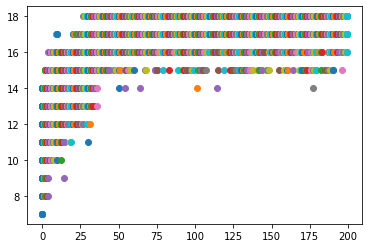

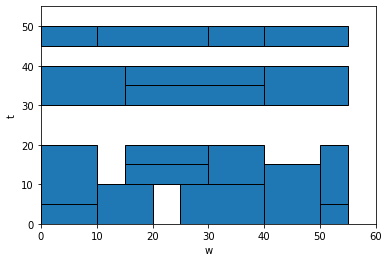

<Figure size 432x288 with 0 Axes>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/Users/linhai/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 24179 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/linhai/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 26041 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/linhai/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/Users/linhai/opt/anaconda3/lib/python3.9/site-packages/matplotlib/bac

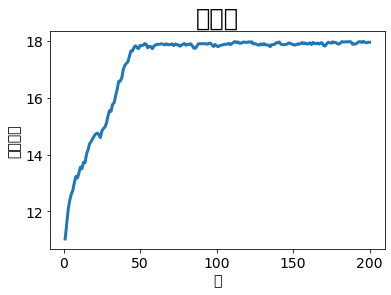

In [14]:
print(f'最后一代种群{pop}')
print(f'目前最大适应度值：{max_F}')
print(f'目前最优基因型：{max_gene}')
print(f'全局最大值：{history_max_Fitness}')
print(f'全局最大基因型：{history_max_gene}')
print(f'全部基因型：{generation_individual_Fitness}')

plt.figure(1)
for i in range(N_GENERATIONS):
    X = [i] * POP_SIZE
    Y = generation_individual_Fitness[i].tolist()          # 转化为列表
    plt.scatter(X, Y)

plt.figure(2)
show_rec(history_max_gene)


plt.figure(3)
input_values = np.arange(1,N_GENERATIONS+1).tolist()
squares = generation_average.tolist()
fig,ax = plt.subplots()
ax.plot(input_values,squares,linewidth=3)
 
#设置图表标题并给坐标轴加上标签。
ax.set_title("平方数", fontsize=24)
ax.set_xlabel("值",fontsize=14)
ax.set_ylabel("值的平方",fontsize=14)
 
#设置刻度标记的大小
ax.tick_params(axis='both',labelsize=14)


plt.show()